In [1]:
import os
from utilities import (extract_image_from_pdf, extract_xml_from_digital_pdf,
                       create_directory, read_directory_files, get_subdirectories,
                       get_string_xmltree, get_xmltree, get_specific_tags, get_page_texts_ordered,
                       get_page_text_element_attrib, get_ngram
                      )
from xml_document_info import (get_xml_info)
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import copy
import cv2
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import glob

pd.set_option('display.max_rows', None)


In [2]:
def normalize_dist(sum_x):
    sum_x = sum_x - sum_x.min()
    sum_x = sum_x * 255.0 / sum_x.max() 

    return sum_x

In [3]:
base_dir    = '/home/dhiraj/Documents/Anuwad/document-structure/data'
input_dir  = os.path.join(base_dir, 'input')
output_dir = os.path.join(base_dir, 'output')

#filename   = 'Testa_Dummy_ImuPro_okt2018_5725.pdf'
#filename   = 'v241.pdf'
#filename   = 'downloaded.pdf'
filename   = '20695_2010_8_1501_20635_Judgement_17-Feb-2020.pdf'
#filename    = '20.03.2020.pdf'
#filename    = '6251_2016_3_1501_19387_Judgement_06-Jan-2020.pdf'
#filename   = '4603_2017_11_1503_19663_Judgement_15-Jan-2020.pdf'
#filename    =  'Kamola2015_Article_Image-basedLogicalDocumentStru.pdf'


os.system('mkdir -p {0}'.format(input_dir))

os.system('mkdir -p {0}'.format(output_dir))



0

In [4]:
pdf_filepath   = os.path.join(input_dir, filename)
working_dir    = os.path.join(output_dir, os.path.splitext(filename)[0])

ret            = create_directory(working_dir)

pdf_image_dir  = extract_image_from_pdf(pdf_filepath, working_dir)
pdf_xml_dir    = extract_xml_from_digital_pdf(pdf_filepath, working_dir)

xml_files      = read_directory_files(pdf_xml_dir, pattern='*.xml')
# print(xml_files, "\n\n")
image_files    = read_directory_files(pdf_image_dir, pattern='*-*.jpg')
# print(image_files)
print("Extracted xml & images of file: %s" % (filename))

Extracted xml & images of file: 20695_2010_8_1501_20635_Judgement_17-Feb-2020.pdf


In [5]:
xml_dfs, page_width, page_height = get_xml_info(xml_files[0])

Total number of pages (54) in file (20695_2010_8_1501_20635_Judgement_17-Feb-2020.xml)


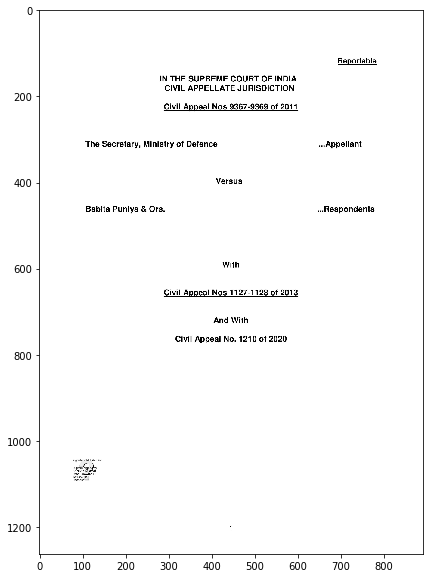

In [6]:
page_index =0
threshold = 125


page_df = xml_dfs[page_index]
page_image = cv2.imread(image_files[page_index],0)
page_image = cv2.resize(page_image, (page_width, page_height)) 


#binary_image =  page_image < threshold
#binary_image = binary_image#.astype(np.uint8)
#binary_image = binary_image * 255

plt.rcParams['figure.figsize'] = [10, 10]

plt.imshow(page_image,cmap='gray')

In [7]:
slate = np.zeros(page_image.shape, np.uint8)
mask = np.zeros((page_height + 2, page_width + 2), np.uint8)

In [25]:
for _ , row in page_df.iterrows():
    cv2.rectangle(slate, (row['text_left'] ,row['text_top']), (row['text_left'] +row['text_width'] ,row['text_top']+row['text_height']) , 1, 1)
    cv2.floodFill(slate,mask , (int(row['text_left'] +row['text_width'] *0.5) ,int(row['text_top']+row['text_height']*0.5)),1)

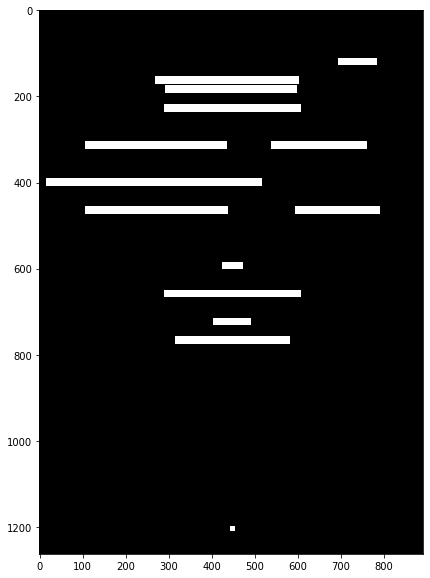

In [26]:
binary_image =  slate > 0.5
plt.imshow(slate*255,cmap='gray')

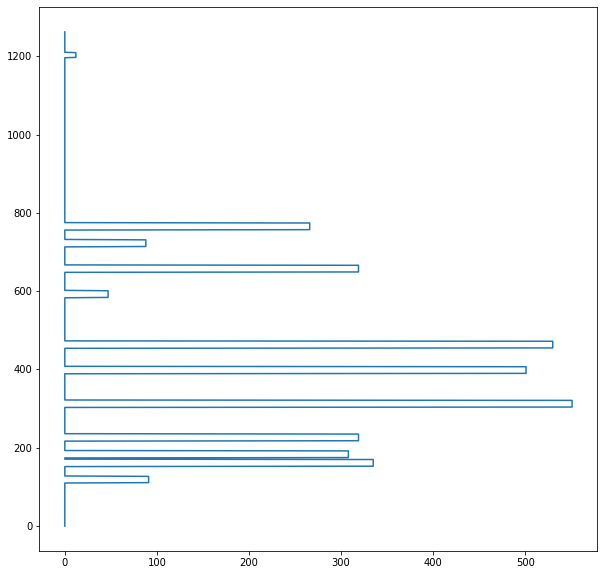

In [10]:
sum_w = slate[:,:].sum(axis=1)
plt.plot(sum_w,[ i for i in range(len(sum_w))])

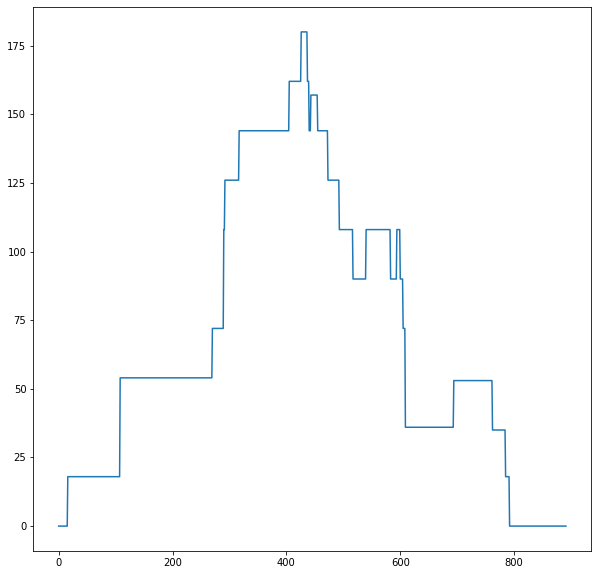

In [11]:
sum_h = slate[:,:].sum(axis=0)
plt.plot(sum_h)

In [12]:
#normalise 
sum_h = normalize_dist(sum_h)
sum_w = normalize_dist(sum_w)


In [13]:
blank_image = np.zeros((page_image.shape[0],page_image.shape[1],3))
filler      = blank_image.copy()

In [14]:
filler_w = blank_image[:,:,0].copy()
filler_h = blank_image[:,:,0].copy()

for index in range(filler_w.shape[0]):
    filler_w[index ,:] = sum_w[index]
    
for index in range(filler_h.shape[1]):
    filler_h[: ,index] = sum_h[index]

In [15]:
blank_image[:,:,0] = filler_w
blank_image[:,:,2] = filler_h
blank_image[:,:,1][binary_image] = 255

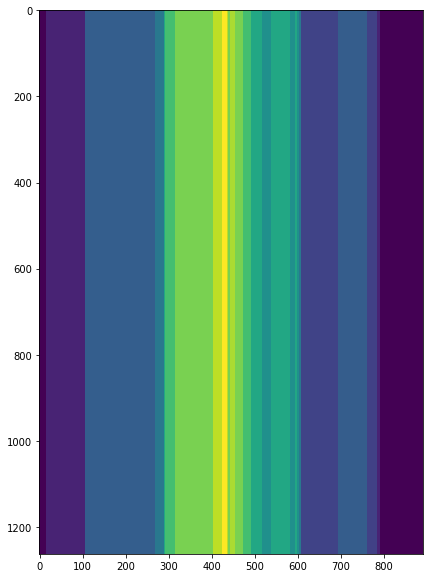

In [16]:
plt.imshow(filler_h)

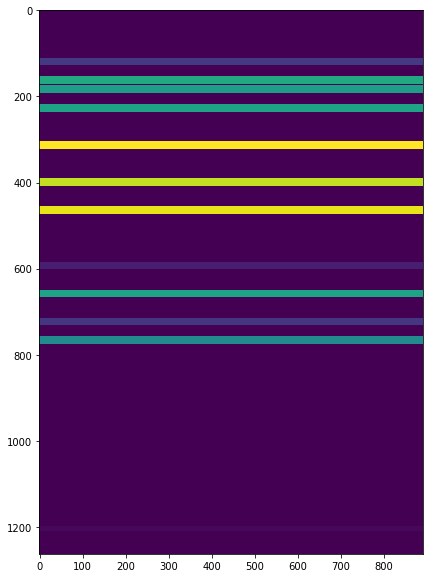

In [17]:
plt.imshow(filler_w)

#helpful in finding tables and regions of sparse text

In [6]:
base_dir    = '/home/dhiraj/Documents/Anuwad/document-structure/data'
input_dir  = os.path.join(base_dir, 'input')
#output_dir = os.path.join(base_dir, 'output')
dist_dir   = os.path.join(base_dir, 'distance_distribution')

#filename   = 'Testa_Dummy_ImuPro_okt2018_5725.pdf'
#filename   = 'v241.pdf'
#filename   = 'downloaded.pdf'
#filename   = '20695_2010_8_1501_20635_Judgement_17-Feb-2020.pdf'
#filename    = '20.03.2020.pdf'
#filename    = '6251_2016_3_1501_19387_Judgement_06-Jan-2020.pdf'
#filename   = '4603_2017_11_1503_19663_Judgement_15-Jan-2020.pdf'

def process_pdf(filename,base_dir):
    dist_dir   = os.path.join(base_dir, 'distance_distribution')

    doc_pattern_dir = os.path.join(dist_dir,filename.split('.')[0]) 

    
    
    input_dir  = os.path.join(base_dir, 'input')
    output_dir = os.path.join(base_dir, 'output')
    dist_dir   = os.path.join(base_dir, 'distance_distribution')

    #os.system('mkdir -p {0}'.format(input_dir))

    os.system('mkdir -p {0}'.format(output_dir))

    os.system('mkdir -p {0}'.format(doc_pattern_dir))


    pdf_filepath   = os.path.join(input_dir, filename)
    working_dir    = os.path.join(output_dir, os.path.splitext(filename)[0])

    ret            = create_directory(working_dir)

    pdf_image_dir  = extract_image_from_pdf(pdf_filepath, working_dir)
    pdf_xml_dir    = extract_xml_from_digital_pdf(pdf_filepath, working_dir)

    xml_files      = read_directory_files(pdf_xml_dir, pattern='*.xml')
    # print(xml_files, "\n\n")
    image_files    = read_directory_files(pdf_image_dir, pattern='*-*.jpg')
    # print(image_files)
    print("Extracted xml & images of file: %s" % (filename))

    xml_dfs, page_width, page_height = get_xml_info(xml_files[0])


    for page_index in range(len(xml_dfs)) :

        page_df = xml_dfs[page_index]
        page_image = cv2.imread(image_files[page_index],0)
        page_image = cv2.resize(page_image, (page_width, page_height)) 

        slate = np.zeros(page_image.shape, np.uint8)
        mask = np.zeros((page_height + 2, page_width + 2), np.uint8)


        for _ , row in page_df.iterrows():
            cv2.rectangle(slate, (row['text_left'] ,row['text_top']), (row['text_left'] +row['text_width'] ,row['text_top']+row['text_height']) , 1, 1)
            cv2.floodFill(slate,mask , (int(row['text_left'] +row['text_width'] *0.5) ,int(row['text_top']+row['text_height']*0.5)),1)


        binary_image =  slate > 0.5
        sum_w = slate[:,:].sum(axis=1) / page_width
        sum_h = slate[:,:].sum(axis=0) / page_height

        #normalise 
        #sum_h = normalize_dist(sum_h)
        #sum_w = normalize_dist(sum_w)

        blank_image = np.zeros((page_image.shape[0],page_image.shape[1],3))
        filler      = blank_image.copy()


        filler_w = blank_image[:,:,0].copy()
        filler_h = blank_image[:,:,0].copy()

        for index in range(filler_w.shape[0]):
            filler_w[index ,:] = sum_w[index] * 255

        for index in range(filler_h.shape[1]):
            filler_h[: ,index] = sum_h[index] * 255


        blank_image[:,:,0] = filler_w
        blank_image[:,:,2] = filler_h
        blank_image[:,:,1][binary_image] = 125
        blank_image[:][~binary_image]    = 0

        
        
        cv2.imwrite(doc_pattern_dir + '/' + str(page_index) + '.png',np.hstack([cv2.cvtColor(page_image,cv2.COLOR_GRAY2RGB),blank_image]))
        

for pdf_file in glob.glob(input_dir + '/*pdf'):
    try :
        print(pdf_file)
        process_pdf(pdf_file.split('/')[-1],base_dir)
    except :
        pass

/home/dhiraj/Documents/Anuwad/document-structure/data/input/FS99-04-007.pdf
Extracted xml & images of file: FS99-04-007.pdf
Total number of pages (8) in file (FS99-04-007.xml)
/home/dhiraj/Documents/Anuwad/document-structure/data/input/000_hi_Presidents_Secretariat_2020-04-25.pdf
Extracted xml & images of file: 000_hi_Presidents_Secretariat_2020-04-25.pdf
Total number of pages (1) in file (000_hi_Presidents_Secretariat_2020-04-25.xml)
/home/dhiraj/Documents/Anuwad/document-structure/data/input/1506.02640.pdf
Extracted xml & images of file: 1506.02640.pdf
Total number of pages (10) in file (1506.02640.xml)
/home/dhiraj/Documents/Anuwad/document-structure/data/input/v241.pdf
Extracted xml & images of file: v241.pdf
Total number of pages (3) in file (v241.xml)
/home/dhiraj/Documents/Anuwad/document-structure/data/input/12_2019_9_1503_21076_Judgement_02-Mar-2020.pdf
Extracted xml & images of file: 12_2019_9_1503_21076_Judgement_02-Mar-2020.pdf
Total number of pages (11) in file (12_2019_9_

In [3]:
input_dir

'/home/dhiraj/Documents/Anuwad/document-structure/data/input'